# Detectando e Interpretando Sinais Periódicos em Séries Temporais Paleobiológicas

**Análise Espectral de Diversidade de Gêneros Marinhos**

**Disciplina:** CCM0228 - Computação IV (2025.1)  
**Autores:**
- Helena Baptista Reis (NUSP: 14577622)
- Luca Marinho Nasser Valadares Paiva (NUSP: 13691375)

## Resumo do Projeto

Este notebook implementa uma análise espectral para detectar e interpretar sinais periódicos em séries temporais paleobiológicas. Utilizamos dados de diversidade de gêneros marinhos ao longo do tempo geológico para investigar padrões cíclicos que podem estar relacionados a processos geológicos, climáticos ou astronômicos.

## Metodologia

1. **Pré-processamento:** Carregamento dos dados e Remoção de tendências de longo prazo
2. **Análise Espectral:** Aplicação de Transformada de Fourier (FFT) e Identificação dos picos relevantes
3. **Construção de Modelos Nulos:** Simulações de Monte Carlo
4. **Validação Estatística:** Teste de significância dos picos relevantes no espectro real e nos simulados

## Organização do Código
O código está organizado em blocos funcionais modulares para máxima reutilização e clareza:

### Configuração e Dependências

In [48]:
# ============================
# CONFIGURAÇÃO E DEPENDÊNCIAS
# ============================

# Imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks

# Configuração de caminhos
DATA_ROOT = Path("data")
GENERA_DATA_PATH = DATA_ROOT / "raw" / "genera_data.csv"
RESULTS_PATH = DATA_ROOT / "processed"

# Configuração de plotagem
plt.style.use('default')
plt.rcParams.update({
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'font.size': 10
})

# Configuração de seeds para reprodutibilidade
np.random.seed(42)

### Módulo de Processamento de Dados
- `carregar_dados()` - Carrega CSV e normaliza diversidade para milhares
- `ajustar_polinomio()` - Ajusta polinômio (de grau 3) para remoção de tendência
- `calcular_residuos()` - Remove tendência (subtrai polinômio de ajustado) e calcula série centrada em zero (resíduos)

In [49]:
# ============================
# MÓDULO: PROCESSAMENTO DE DADOS
# ============================

def carregar_dados(caminho_arquivo):
    """
    Carrega um arquivo CSV contendo dados de diversidade ao longo do tempo.

    Args:
        caminho_arquivo: Caminho para o arquivo CSV contendo os dados
    
    Returns: DataFrame, Tempo, Diversidade normalizada
    """
    df = pd.read_csv(caminho_arquivo)
    x = df["TimeBin"].values
    y = (df["Diversity"] / 1000).values  # Diversidade convertida para milhares de gêneros
    
    return df, x, y


def ajustar_polinomio(y, grau=3):
    """
    Ajusta polinômio para remoção de tendência.
    
    Args:
        y: Série temporal
        grau: Grau do polinômio (default=3)
    
    Returns: Função polinomial ajustada
    """
    x_indices = np.arange(len(y)) # Vetor de índices inteiros para o ajuste polinomial
    
    coeficientes = np.polyfit(x_indices, y, grau)
    polinomio = np.poly1d(coeficientes)
    
    return polinomio


def calcular_residuos(y, polinomio):
    """
    Remove tendência calculando resíduos centrados em zero.

    Args:
        y: Série temporal
        polynomial: Função polinomial ajustada
    
    Returns: Série de resíduos (dados - tendência)
    """
    x_indices = np.arange(len(y))
    
    tendencia = polinomio(x_indices) # Avalia o polinômio nos índices
    residuos = y - tendencia
    
    return residuos

### Módulo de Análise Espectral
- `calcular_espectro_potencia()` - Aplica FFT com padding opcional (para melhora da resolução do espectro)
- `identificar_picos_espectrais()` - Detecta picos com threshold adaptativo

In [50]:
# ============================
# MÓDULO: ANÁLISE ESPECTRAL
# ============================

def calcular_espectro_potencia(serie, pad=1):
    """
    Calcula espectro de potência via FFT.
    
    Args:
        series: Série temporal
        pad: Fator de zero-padding (default=1)
    
    Returns: Frequências positivas, Potências normalizadas
    """
    # Preenche a série com zeros até o tamanho desejado
    N = len(serie)
    N_pad = pad * N
    serie_padded = np.pad(serie, (0, N_pad - N), 'constant') 

    # Calcula FFT e potências
    freqs = fftfreq(len(serie_padded)) 
    fft_vals = fft(serie_padded)
    potencia = (np.abs(fft_vals) / len(serie_padded))**2 
    
    # Filtra frequências positivas e relevantes (período > 20 Myr, 0 < f < 0.05)
    mask = (freqs > 0) & (freqs < 0.05)
    freqs_positivas = freqs[mask]
    potencias_positivas = potencia[mask]
    
    return freqs_positivas, potencias_positivas


def identificar_picos_espectrais(freqs, pots, threshold=0.1, distancia_minima=0.02):
    """
    Identifica picos estatisticamente relevantes.

    Args:
        freqs: Vetor de frequências do espectro
        pots: Vetor de potências do espectro
        threshold: Fração da potência máxima para detectar pico (default=0.1)
        distancia_minima: Distância mínima entre picos, em fração do intervalo total de frequências (default=0.02)

    Returns: Índices dos picos, Alturas dos picos
    """
    threshold *= np.max(pots) # Valor absoluto do threshold baseado na potência máxima

    # Calcula a distância mínima entre picos em termos de índices
    range_freqs = freqs[-1] - freqs[0]
    distancia_minima *= range_freqs 
    indices_distancia_minima = int(distancia_minima / (freqs[1] - freqs[0]))

    # Encontra picos
    picos, propriedades = find_peaks(pots, height=threshold, distance=max(indices_distancia_minima, 1))
    alturas = propriedades['peak_heights']

    return picos, alturas

### Módulo de Visualização
- `plotar_serie_temporal()` - Plot da série temporal, opcionalmente contendo polinômio ajustado e resíduos
- `plotar_espectro_potencia()` - Plot do espectro de potências, opcionalmente contendo modelos nulos
- `criar_dashboard_completo()` - Dashboard integrado multi-painel

In [51]:
# ============================
# MÓDULO: VISUALIZAÇÃO
# ============================

def plotar_serie_temporal(x, y, titulo, nome_arquivo, polinomio=None, residuos=None):
    """
    Plota séries temporais.
    
    Args:
        x, y: Dados temporais
        titulo: Título do gráfico
        nome_arquivo: Nome para salvar
        polinomio: Função polinomial (opcional)
        residuos: Série de resíduos (opcional)
        
    Returns: None
    """
    # Configurações padrão
    config = {
        'figsize': (8, 6),
        'xlim': (0, 542), 'xticks': np.arange(0, 542, 100),
        'ylim': (-1, 5.5), 'yticks': np.arange(0, 6),
        'cores': {'serie': 'black', 'tendencia': 'red', 'residuos': 'blue'},
        'estilos': {
            'serie': {'linewidth': 0.8, 'alpha': 0.8},
            'tendencia': {'linewidth': 1.2, 'linestyle': '-'},
            'residuos': {'linewidth': 0.8, 'alpha': 0.8}
        }
    }

    # Cria figura e plot principal
    fig, ax = plt.subplots(figsize=config['figsize'])
    ax.stairs(  y, 
                linewidth=config['estilos']['serie']['linewidth'], 
                color=config['cores']['serie'], 
                alpha=config['estilos']['serie']['alpha'],
                label="Série Temporal")
    
    # Adiciona tendência (se fornecida)
    if polinomio is not None:
        x_indices = np.arange(len(y))
        tendencia = polinomio(x_indices)
        ax.plot(x, tendencia, color=config['cores']['tendencia'], 
                linewidth=config['estilos']['tendencia']['linewidth'],
                linestyle=config['estilos']['tendencia']['linestyle'],
                label="Tendência")
    
    # Adiciona resíduos (se fornecidos)
    if residuos is not None:
        ax.plot(x, residuos, color=config['cores']['residuos'], 
                linewidth=config['estilos']['residuos']['linewidth'],
                alpha=config['estilos']['residuos']['alpha'], 
                label="Resíduos")
    
    # Configurações finais
    ax.set(xlim=config['xlim'], xticks=config['xticks'],
           ylim=config['ylim'], yticks=config['yticks'],
           xlabel="Idade (Myr)", ylabel="Diversidade (milhares de gêneros)", title=titulo)
    
    if polinomio is not None or residuos is not None:
        ax.legend(loc="upper right", framealpha=0.9)
    
    # Salva e mostra gráfico
    plt.tight_layout()
    plt.savefig(str(RESULTS_PATH / nome_arquivo))
    plt.show()


def plotar_espectro_potencia(
    freqs, pots, titulo, nome_arquivo, picos=None,
    freqs_modelo1=None, pots_modelo1=None, label_modelo1=None,
    freqs_modelo2=None, pots_modelo2=None, label_modelo2=None
):
    """
    Plota espectros de potência com até dois modelos nulos e picos.

    Args:
        freqs, pots: Dados espectrais originais
        titulo: Título do gráfico
        nome_arquivo: Nome para salvar
        picos: Índices dos picos (opcional)
        freqs_modelo1, pots_modelo1: Dados do primeiro modelo nulo (opcional)
        label_modelo1: Rótulo do primeiro modelo nulo (opcional)
        freqs_modelo2, pots_modelo2: Dados do segundo modelo nulo (opcional)
        label_modelo2: Rótulo do segundo modelo nulo (opcional)

    Returns: None
    """
    # Configurações padrão
    config = {
        'figsize': (8, 6),
        'cores': {'original': 'black', 'modelo1': 'blue', 'modelo2': 'green', 'picos': 'red'},
        'estilos': {
            'original': {'linewidth': 0.8, 'alpha': 0.8},
            'modelo1': {'linewidth': 1.2, 'linestyle': '--'},
            'modelo2': {'linewidth': 1.2, 'linestyle': ':'},
            'threshold': {'linestyle': '--', 'alpha': 0.8}
        }
    }

    # Cria figura e plot principal
    fig, ax = plt.subplots(figsize=config['figsize'])
    ax.plot(freqs, pots, color=config['cores']['original'],
           linewidth=config['estilos']['original']['linewidth'],
           alpha=config['estilos']['original']['alpha'], label='Espectro Original')

    # Adiciona modelo 1 (se fornecido)
    if freqs_modelo1 is not None and pots_modelo1 is not None:
        ax.plot(freqs_modelo1, pots_modelo1, color=config['cores']['modelo1'],
                linewidth=config['estilos']['modelo1']['linewidth'],
                linestyle=config['estilos']['modelo1']['linestyle'],
                label=label_modelo1 or 'Modelo Nulo 1')

    # Adiciona modelo 2 (se fornecido)
    if freqs_modelo2 is not None and pots_modelo2 is not None:
        ax.plot(freqs_modelo2, pots_modelo2, color=config['cores']['modelo2'],
                linewidth=config['estilos']['modelo2']['linewidth'],
                linestyle=config['estilos']['modelo2']['linestyle'],
                label=label_modelo2 or 'Modelo Nulo 2')

    # Identifica e plota picos (se fornecidos)
    if picos is not None:
        ax.plot(freqs[picos], pots[picos], 'ro', markersize=8,
                markerfacecolor=config['cores']['picos'], markeredgecolor='white',
                markeredgewidth=1, label='Picos Identificados')
        for i in picos:
            periodo = 1 / freqs[i]
            ax.annotate(f'{periodo:.0f} Myr', (freqs[i], pots[i]),
                        textcoords="offset points", xytext=(0, 10), ha='center',
                        fontsize=9, fontweight='bold', color=config['cores']['picos'],
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                                  edgecolor=config['cores']['picos'], alpha=0.8))

    # Configurações finais
    ax.set(xlim=(0, 0.05), ylim=(0, np.max(pots) * 1.1), xticks=np.arange(0, 0.06, 0.01),
           xlabel='Frequência (ciclos Myr⁻¹)', ylabel='Potência espectral', title=titulo)
    if (
        (freqs_modelo1 is not None and pots_modelo1 is not None) or
        (freqs_modelo2 is not None and pots_modelo2 is not None) or
        (picos is not None)
    ):
        ax.legend(loc='upper right', framealpha=0.9)

    # Salva e mostra gráfico
    plt.tight_layout()
    plt.savefig(str(RESULTS_PATH / nome_arquivo))
    plt.show()

# Não mexi, acho inútil
def criar_dashboard_completo(dados_dict, nome_arquivo="dashboard_completo.png"):
    """
    Cria dashboard integrado com múltiplos painéis.
    
    Args:
        dados_dict: Dicionário com todos os dados necessários
        nome_arquivo: Nome do arquivo para salvar
    
    Returns: (figura, eixos)
    """
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1], width_ratios=[1, 1],
                         hspace=0.3, wspace=0.3)
    
    # 1. Série temporal original
    ax1 = fig.add_subplot(gs[0, :])
    x, y = dados_dict['x'], dados_dict['y']
    ax1.stairs(y, linewidth=1, color='black', alpha=0.8)
    ax1.set_title('Série Temporal de Diversidade', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Idade (Myr)')
    ax1.set_ylabel('Diversidade (mil gêneros)')
    ax1.grid(True, alpha=0.3)
    
    # 2. Série com tendência removida
    ax2 = fig.add_subplot(gs[1, 0])
    if 'residuos' in dados_dict:
        ax2.plot(x, dados_dict['residuos'], 'b-', linewidth=1, alpha=0.8)
        ax2.set_title('Resíduos (Tendência Removida)')
        ax2.set_xlabel('Idade (Myr)')
        ax2.set_ylabel('Resíduos')
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    # 3. Espectro de potência
    ax3 = fig.add_subplot(gs[1, 1])
    if 'freqs' in dados_dict and 'pots' in dados_dict:
        freqs, pots = dados_dict['freqs'], dados_dict['pots']
        ax3.plot(freqs, pots, 'b-', linewidth=1.5)
        ax3.set_title('Espectro de Potência')
        ax3.set_xlabel('Frequência (ciclos/Myr)')
        ax3.set_ylabel('Potência')
        ax3.grid(True, alpha=0.3)
        
        if 'picos' in dados_dict:
            picos = dados_dict['picos']
            ax3.plot(freqs[picos], pots[picos], 'ro', markersize=6)
    
    # 4. Comparação com modelos nulos
    ax4 = fig.add_subplot(gs[2, :])
    if all(k in dados_dict for k in ['freqs', 'pots', 'freqs_r', 'pots_r']):
        ax4.plot(freqs, pots, 'b-', linewidth=1.5, label='Original', alpha=0.8)
        ax4.plot(dados_dict['freqs_r'], dados_dict['pots_r'], 'r--', linewidth=1.2, label='Modelo R')
        
        if 'freqs_w' in dados_dict and 'pots_w' in dados_dict:
            ax4.plot(dados_dict['freqs_w'], dados_dict['pots_w'], 'g--', linewidth=1.2, label='Modelo W')
        
        ax4.set_title('Comparação com Modelos Nulos')
        ax4.set_xlabel('Frequência (ciclos/Myr)')
        ax4.set_ylabel('Potência')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    
    plt.suptitle('Dashboard de Análise Espectral Paleobiológica', fontsize=16, fontweight='bold', y=0.95)
    plt.savefig(str(RESULTS_PATH / nome_arquivo))
    plt.show()
    
    print(f"✓ Dashboard salvo: {nome_arquivo}")
    return fig, (ax1, ax2, ax3, ax4)

### Módulo de Modelos Nulos
- `modelo_r()` - Random Walk: Realiza simulações de Monte Carlo embaralhando incrementos
- `modelo_w()` - Windowed Bootstrap: Realiza simulações de Monte Carlo embaralhando blocos
- `_embaralhar_incrementos()` - Função auxiliar para implementação do Modelo R
- `_embaralhar_blocos()` - Função auxiliar para implementação do Modelo W
- `_simular_e_calcular_espectros()` - Função auxiliar para cálculo do espectro médio dos modelos nulos

In [52]:
# ============================
# MÓDULO: MODELOS NULOS (MONTE CARLO)
# ============================

def modelo_r(y, grau=3, n_simulacoes=30000, pad=1):
    """
    Modelo R (Random Walk): Embaralhamento de incrementos da série original.

    Args:
        y: Série temporal original (array 1D)
        grau: Grau do polinômio para remoção de tendência (default=3)
        n_simulacoes: Número de simulações Monte Carlo (default=30000)
        pad: Fator de padding para FFT (default=1)

    Returns:
        freqs: Vetor de frequências
        espectro_medio: Média dos espectros simulados
        espectros_individuais: Array (n_simulacoes, n_freqs) com todos os espectros simulados
    """
    series_simuladas = _embaralhar_incrementos(y, n_simulacoes)
    freqs, espectro_medio, espectros_individuais = _simular_e_calcular_espectros(
        series_simuladas, detrend=True, grau=grau, pad=pad, retornar_todos=True
    )
    return freqs, espectro_medio, espectros_individuais



def modelo_w(residuos, n_blocos=20, n_simulacoes=30000, pad=1):
    """
    Modelo W (Windowed Bootstrap): Embaralhamento de blocos.

    Args:
        residuos: Série de resíduos original (já sem tendência)
        n_blocos: Número de blocos em que a série será dividida (default=20)
        n_simulacoes: Número de simulações Monte Carlo (default=30000)
        pad: Fator de padding para FFT (default=1)

    Returns:
        freqs: Vetor de frequências
        espectro_medio: Média dos espectros simulados
        espectros_individuais: Array (n_simulacoes, n_freqs) com todos os espectros simulados
    """
    series_simuladas = _embaralhar_blocos(residuos, n_simulacoes, n_blocos)
    freqs, espectro_medio, espectros_individuais = _simular_e_calcular_espectros(
        series_simuladas, detrend=False, pad=pad, retornar_todos=True
    )
    return freqs, espectro_medio, espectros_individuais


def _embaralhar_incrementos(y, n_simulacoes):
    """
    Gera séries simuladas embaralhando incrementos (modelo R).

    Args:
        y: Série temporal original (array 1D)
        n_simulacoes: Número de séries simuladas a serem geradas

    Returns:
        Lista de séries simuladas
    """
    incrementos = np.diff(y)
    
    series_simuladas = []
    for _ in range(n_simulacoes):
        inc_embaralhados = np.random.permutation(incrementos)
        serie_sim = np.zeros(len(y))
        serie_sim[0] = y[0]
        for j in range(1, len(y)):
            serie_sim[j] = serie_sim[j-1] + inc_embaralhados[j-1]
        series_simuladas.append(serie_sim)
    return series_simuladas


def _embaralhar_blocos(serie, n_simulacoes, n_blocos=20):
    """
    Divide a série de resíduos em blocos contíguos e embaralha esses blocos para gerar séries simuladas.

    Args:
        serie: Série de resíduos original (array 1D)
        n_blocos: Número de blocos em que a série será dividida (default=20)
        n_simulacoes: Número de séries simuladas a serem geradas

    Returns:
        Lista de séries simuladas
    """
    n_pontos = len(serie)
    tamanho_bloco = int(np.ceil(n_pontos / n_blocos))
    blocos = [serie[j:min(j + tamanho_bloco, n_pontos)] for j in range(0, n_pontos, tamanho_bloco)]
    blocos = np.array(blocos, dtype=object)

    series_simuladas = []
    for _ in range(n_simulacoes):
        indices_embaralhados = np.random.permutation(len(blocos))
        blocos_embaralhados = blocos[indices_embaralhados]
        serie_simulada = np.concatenate(blocos_embaralhados)[:n_pontos]
        series_simuladas.append(serie_simulada)
    return series_simuladas


def _simular_e_calcular_espectros(series_simuladas, detrend=True, grau=3, pad=1, retornar_todos=False):
    """
    Calcula espectros de potência para uma lista de séries simuladas.

    Args:
        series_simuladas: Lista de séries simuladas (arrays 1D)
        detrend: Se True, remove tendência polinomial antes da FFT (default=True)
        grau: Grau do polinômio para detrending (default=3)
        pad: Fator de zero-padding para FFT (default=1)
        retornar_todos: Se True, retorna também todos os espectros individuais

    Returns:
        freqs_comum: Vetor de frequências comum a todas as simulações
        espectro_medio: Espectro médio das simulações
        espectros_pots (opcional): Array (n_simulacoes, n_freqs) com todos os espectros simulados
    """
    espectros_pots = []
    freqs_comum = None
    for serie in series_simuladas:
        if detrend:
            polinomio = ajustar_polinomio(serie, grau=grau)
            residuos = calcular_residuos(serie, polinomio)
            dados_fft = residuos
        else:
            dados_fft = serie
        freqs, pots = calcular_espectro_potencia(dados_fft, pad=pad)

        if freqs_comum is None:
            freqs_comum = freqs
        espectros_pots.append(pots)

    espectros_pots = np.array(espectros_pots)
    espectro_medio = np.mean(espectros_pots, axis=0)

    if retornar_todos:
        return freqs_comum, espectro_medio, espectros_pots
    else:
        return freqs_comum, espectro_medio

### Módulo de Testes de Significância

In [53]:
# ============================
# MÓDULO: TESTES DE SIGNIFICÂNCIA
# ============================

# Compare o pico de 62 Myr do espectro real com os espectros simulados.
# Estime um valor de p com base na fração de simulações que produziram picos iguais ou maiores.

## Índice das Etapas

**Etapa 1:** Exploração Inicial dos Dados
**Etapa 2:** Remoção da Tendência (Ajuste Polinomial)  
**Etapa 3:** Análise Espectral por FFT  
**Etapa 4:** Construção de Modelos Nulos (Monte Carlo)  
**Etapa 5:** Teste de Significância Estatística  
**Etapa 6:** Discussão e Interpretação dos Resultados

## Etapa 1 - Exploração Inicial dos Dados

Carregamos dados de diversidade de gêneros marinhos ao longo do tempo geológico e fazemos análise exploratória inicial.

In [54]:
df, x, y = carregar_dados(GENERA_DATA_PATH)
df

,TimeBin,Diversity
0,0.0,4166.0
1,1.0,4166.0
2,2.0,4062.5
3,3.0,4062.5
4,4.0,3941.5
...,...,...
537,537.0,47.0
538,538.0,16.0
539,539.0,16.0
540,540.0,16.0


Plotamos a diversidade ao longo do tempo geológico.

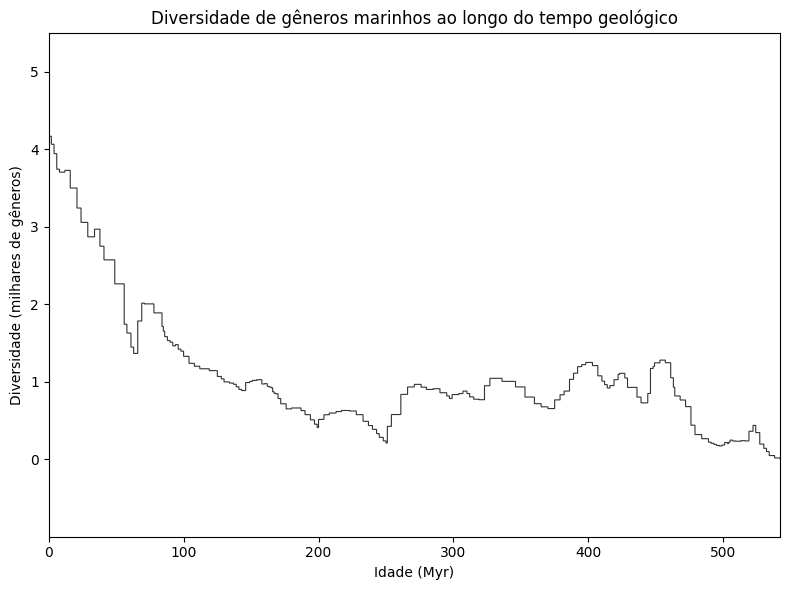

In [55]:
plotar_serie_temporal(x, y, 
                     "Diversidade de gêneros marinhos ao longo do tempo geológico",
                     "etapa1_diversidade_generos.png")

**Observações:**
- Tendência decrescente no longo prazo, e acentuada nos primeiros 80 Myr
- Picos notáveis: ~80, ~280-450, ~500 Myr
- Vales: ~100-250, ~450-500 Myr
- Possíveis padrões cíclicos superpostos à tendência

## Etapa 2 - Remoção da Tendência (Ajuste Polinomial)

Para isolar flutuações periódicas, ajustamos um polinômio de grau 3 removendo tendência de longo prazo.

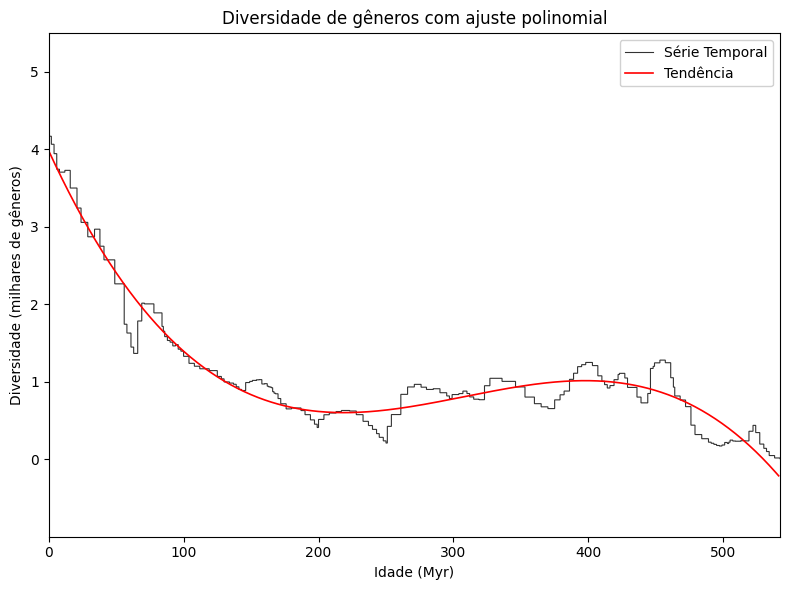

In [56]:
polinomio = ajustar_polinomio(y, grau=3)

plotar_serie_temporal(x, y,
                     "Diversidade de gêneros com ajuste polinomial",
                     "etapa2_remocao_tendencia.png",
                     polinomio=polinomio)

Subtraímos a tendência para obter resíduos apropriados para análise espectral.

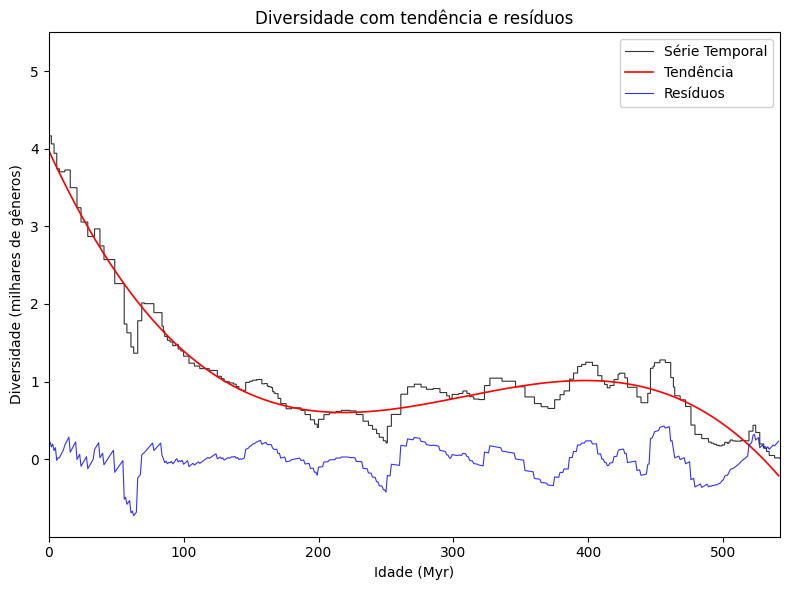

In [57]:
residuos = calcular_residuos(y, polinomio)

plotar_serie_temporal(x, y,
                     "Diversidade com tendência e resíduos",
                     "etapa2_residuos.png",
                     polinomio=polinomio,
                     residuos=residuos)

## Etapa 3 - Análise Espectral por FFT

Aplicamos FFT aos resíduos para decompor a série em diferentes frequências e identificar oscilações periódicas.

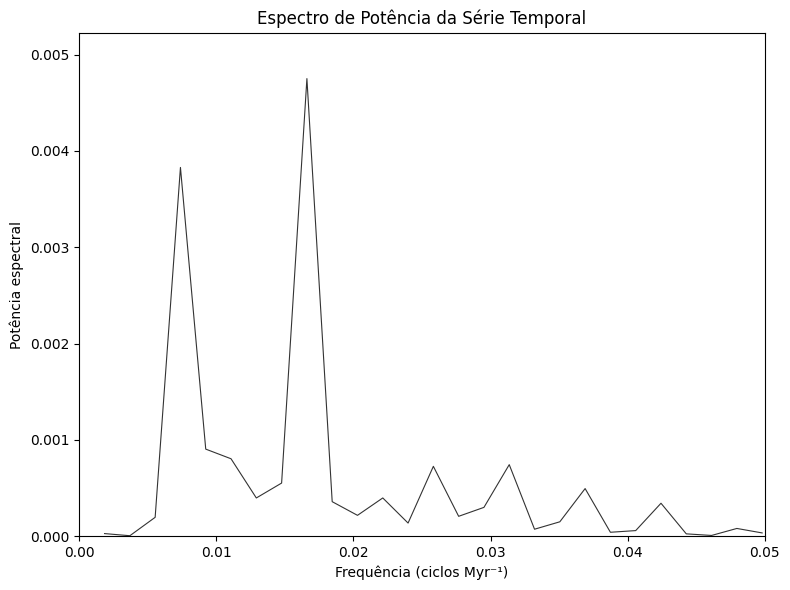

In [58]:
freqs, pots = calcular_espectro_potencia(residuos)

plotar_espectro_potencia(freqs, pots,
                        'Espectro de Potência da Série Temporal',
                        'etapa3_espectro_potencia.png')

Aplicamos padding (fator 7) para melhorar resolução espectral.

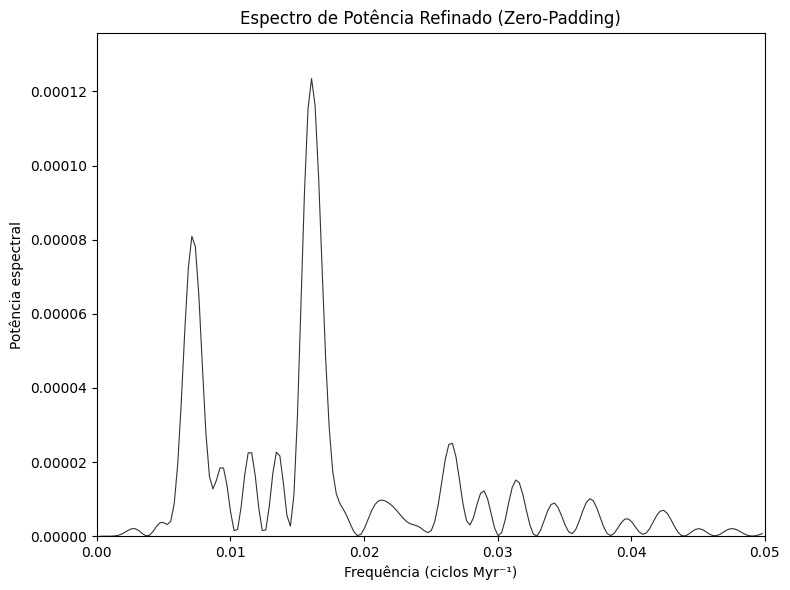

In [59]:
freqs_ref, pots_ref = calcular_espectro_potencia(residuos, pad=7)

plotar_espectro_potencia(freqs_ref, pots_ref,
                        'Espectro de Potência Refinado (Zero-Padding)',
                        'etapa3_espectro_potencia_refinado.png')

Procedemos à identificação de picos relevantes estabelecendo um threshold de 25% da potência máxima.

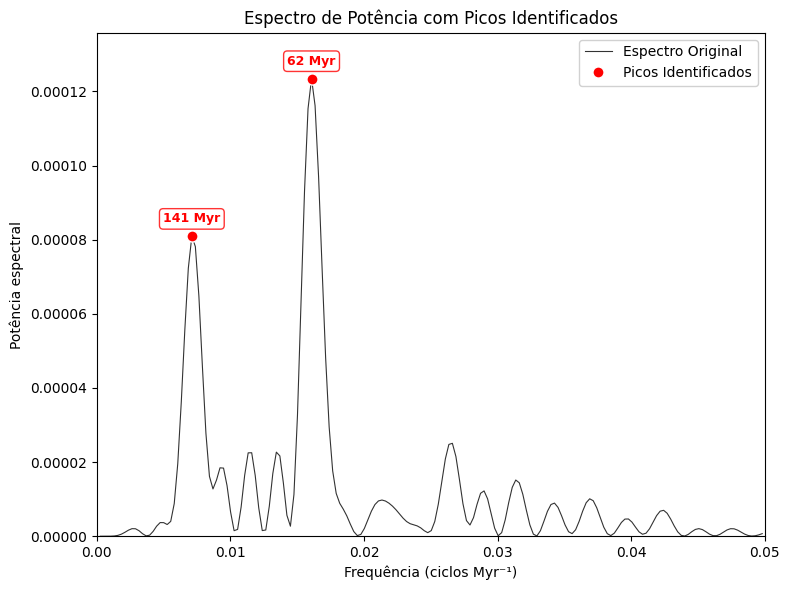

In [60]:
picos, propriedades = identificar_picos_espectrais(freqs_ref, pots_ref, threshold=0.25)

plotar_espectro_potencia(freqs_ref, pots_ref,
                        'Espectro de Potência com Picos Identificados',
                        'etapa3_espectro_com_picos_threshold_25.png',
                        picos=picos)

**Resultado:** Dois picos relevantes identificados em 62 e 141 Myr.

## Etapa 4 - Construção de Modelos Nulos (Monte Carlo)

Testamos significância dos picos com simulações que preservam características estatísticas dos dados originais.

**Estratégia:** Dois modelos complementares:
- **Modelo R:** Embaralhamento de incrementos (passeio aleatório)
- **Modelo W:** Embaralhamento de blocos (preserva autocorrelações locais)

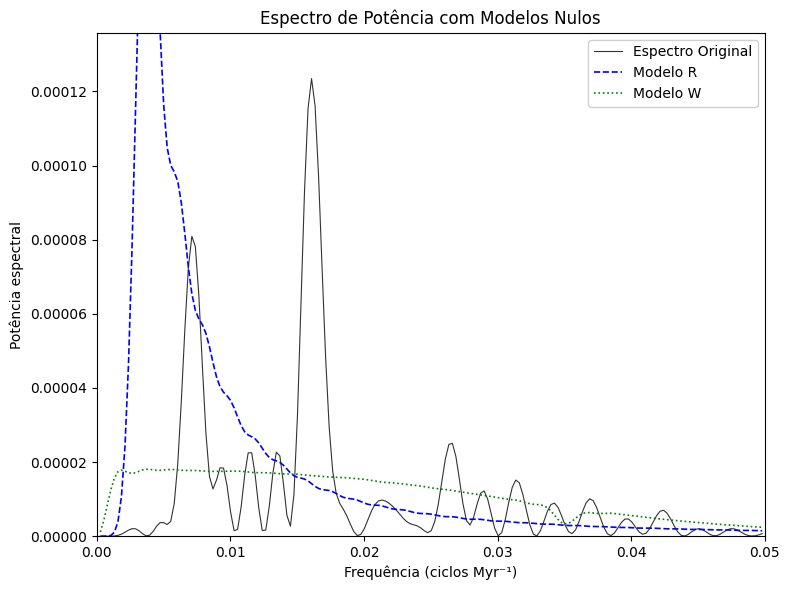

In [61]:
freqs_r, pots_r, individuais_r = modelo_r(y, grau=3, n_simulacoes=30000, pad=7)

freqs_w, pots_w, individuais_w = modelo_w(residuos, n_blocos=20, n_simulacoes=30000, pad=7)

plotar_espectro_potencia(freqs_ref, pots_ref,
                        'Espectro de Potência com Modelos Nulos',
                        'etapa4_modelo_r_espectro.png',
                        freqs_modelo1=freqs_r, pots_modelo1=pots_r, label_modelo1='Modelo R',
                        freqs_modelo2=freqs_w, pots_modelo2=pots_w, label_modelo2='Modelo W')

## Etapa 5 - Teste de Significância Estatística

Testamos significância estatística dos picos comparando-os com modelos nulos (critério: 95% de confiança em ambos os modelos).

## Etapa 6 - Discussão e Interpretação

Períodos identificados podem estar relacionados a:
- Ciclos climáticos de longo prazo
- Variações na atividade tectônica  
- Impactos extraterrestres periódicos
- Ciclos de extinção e radiação adaptativa

**Conclusão:** A utilização de dois modelos nulos distintos e exigência de significância em ambos garante robustez estatística, demonstrando a utilidade de métodos espectrais rigorosos na detecção de padrões periódicos em dados paleobiológicos.